Notebook created by Forrest Hooton

In [1]:
from time import time
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
# For higher resolution production graphs
mpl.rcParams['figure.dpi']= 150

In [3]:
import src.pubmed_util as PMD
from src import collected_data_handling

In [4]:
import src.tools.chemidr.labeler as lbr
import src.tools.chemidr.id_map as id_map

# Loading and Formatting Data

In [5]:
import os
import time

# Function to quickly clean plot
def clean_plot():
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

# Function to quickly record given statistics
def report_stat(text, filename, varname=None):
    if not os.path.exists('stats'):
        os.mkdir('stats')
        
    if varname is not None:
        text = text + '\n\tVar: ' + varname
    
    text = text + '\t' + time.strftime("%m/%d/%Y", time.localtime())
    
    with open('stats/' + filename, 'w') as f:
        f.write(text)

# Problem inputing letters into csv, so created system to convert them here
def greek_letter_converter(chem, convert_letter = True):
    if convert_letter:
        chem = chem.replace('*alpha*', 'α')
        chem = chem.replace('*beta*', 'β')
        chem = chem.replace('*gamma*', 'γ')
        chem = chem.replace('*rho*', 'ρ')
        chem = chem.replace('*delta*', 'δ')
    else:
        chem = chem.replace('*alpha*', 'alpha')
        chem = chem.replace('*beta*', 'beta')
        chem = chem.replace('*gamma*', 'gamma')
        chem = chem.replace('*rho*', 'rho')
        chem = chem.replace('*delta*', 'delta')
    return chem

# Clean terms for various file applications
def clean_term(term, convert_letter = True, w_space = True, is_url=True):
    term = term.lower().strip()
    
    if convert_letter:
        term = greek_letter_converter(term)
    else:
        term = greek_letter_converter(term, convert_letter=False)
    
    if w_space:
        if is_url:
            term = term.replace(' ', '%20') # To replace ' ' in request
        else:
            pass
    else:
        term = term.replace(' ', '')
    return term

In [6]:
def id_loader(df, chem_key, load, file, fdb=True, pubchem=True):
    
    if load:
        df = pd.read_pickle(f'data/{file}')
    else:
        df = lbr.id_searcher(df, chem_key, fdb=fdb, pubchem=pubchem)
        df.to_pickle(f'misc_save/{file}')
    
    df.rename(columns={'pubchem_id' : 'chem_id_p', 'foodb_id' : 'chem_id_f'}, inplace=True)
    
    return df

In [7]:
i = 1

def config(i):
    if i == 1:
        food = 'garlic'
    elif i == 2:
        food = 'cocoa'
    
    return food

food = config(i)
load = True

## Pilot Data

In [8]:
def load_raw_data(food, load):
    food_data = pd.read_csv(f'data/{food}_data.csv', encoding='latin1')
    
    food_scoring = pd.read_csv(f'data/{food}_scoring.csv', encoding='latin1')

    # Need to remove phenol explorer ids that were manually put into data (for garlic only)
    food_data = food_data[food_data.PMID.isin(food_scoring.PMID.tolist())]

    food_data.chemical = food_data.chemical.str.lower()
    food_data.amount = food_data.amount.str.replace(',', '')

    food_data = food_data.merge(food_scoring[['PMID','is_useful']], how = 'left', on = 'PMID')
    
    return food_data, food_scoring

food_data, food_scoring = load_raw_data(food, load)

report_stat(f'Number of papers in search {food}: ' + str(len(food_scoring)), f'num_papers_srch_{food}.txt')
report_stat(f'Number of papers reviewed {food}: ' + str(len(food_scoring[food_scoring.is_useful.notnull()])), f'num_reviewed_papers_{food}.txt')

Note: Keys appended October 2018. Keys subject to change with changing PubMed database.

In [9]:
def append_keys_raw_data(food_data, food):
    if load:
        food_data = pd.read_pickle(f'data/{food}_food_data.pkl')
    else:
        food_data = id_loader(food_data, 'chemical', load, f'{food}_food_data.pkl')
    
    return food_data

food_data = append_keys_raw_data(food_data, food)

In [10]:
# Number of unique papers in garlic_test.csv
print('Number of unique papers:', len(food_data['PMID'].drop_duplicates()))
print('Total number of records:', len(food_data))

report_stat(f'Number of unique papers {food}: ' + str(len(food_data['PMID'].drop_duplicates())), f'num_unique_papers_{food}.txt')
report_stat(f'Total number of records {food}: ' + str(len(food_data)), f'num_records_{food}.txt')

Number of unique papers: 77
Total number of records: 1426


In [11]:
# Make units processable
# Not all units were entered cleanly, so this function ensures that the data works for collected_data_handling
def unit_clean(df):
    df.units = df.units.replace('ug/ml', 'ug/L')
    df.units = df.units.replace('U/ml', 'ug/L')
    df.units = df.units.replace('mg/ml', 'ug/L')
    df.units = df.units.replace('mg/l', 'ug/L')
    df.units = df.units.replace('g/l', 'ug/L')
    df.units = df.units.replace('mM', 'ug/L')
    df.units = df.units.replace('mg/ ECE g', 'ug/L')
    df.units = df.units.replace('m/z', '%')
    df.units = df.units.replace('mg/lg', 'ug/L')
    df.units = df.units.replace('mmol/g', 'ug/L')
    df.units = df.units.replace('-', 'ug/L')

    df.amount = df.amount.str.strip('~')
    df.amount = df.amount.str.strip('<')

    # Replace with value of 0 when experiments measured quantified contents, but had no detection 
    df.amount = df.amount.replace('not quantified', '0')
    df.amount = df.amount.replace('LOD', '0')
    df.amount = df.amount.replace('ND', '0')
    df.amount = df.amount.replace('NQ', '0')
    df.amount = df.amount.replace('nd', '0')
    df.amount = df.amount.replace('n.q', '0')
    df.amount = df.amount.replace('n.q.', '0')
    df.amount = df.amount.replace('no analyzed', '0')
    df.amount = df.amount.replace('-', '0')
    
    return df

def clean_raw_data_strings(food_data):
    food_data.chemical = food_data.chemical.apply(clean_term, is_url=False)
    food_data = unit_clean(food_data)
    
    return food_data

food_data = clean_raw_data_strings(food_data)

In [12]:
# Partition data into quantified and unquantified
def partition_raw_data(food_data, food_scoring):

    for idx, row in food_data.iterrows():
        try:
            row['units'].count('g')
        except:
            print(row['units'])

        if row['units'].count('g') > 1:
            food_data.at[idx, 'is_quant'] = 1
        else:
            food_data.at[idx, 'is_quant'] = 0

    # Remove all rows where the units are %'s
    food_data_q = food_data[food_data['is_quant'] == 1].reset_index(drop=True)

    # Have a seperate dataframe for all chemicals that we would put in the category of 'detected but not quantified'
    food_data_dnq = food_data[food_data['is_quant'] == 0].reset_index(drop=True)

     # The quantified dataframe for values that are both quantified and unquantified
    unq_chems = list(set( food_data_dnq['chemical'].tolist() ))
    food_data_both = food_data_q.iloc[[idx for idx, row in food_data_q.fillna('placeholder').iterrows() if row['chemical'] in unq_chems]]

    # Remove occurances of overlaping chemicals from the unquantified garlic data
    q_chems = list(set( food_data_q['chemical'].tolist() ))
    food_data_dnq = food_data_dnq.iloc[[idx for idx, row in food_data_dnq.fillna('placeholder').iterrows() if row['chemical'] not in q_chems]]
    
    return food_data_q, food_data_dnq

food_data_q, food_data_dnq = partition_raw_data(food_data, food_scoring)

In [13]:
# Creates food_mine database data from raw collected data
def build_food_mine(food_data, food_data_q, food_data_dnq):
    food_mine = collected_data_handling.build_data_dict(food_data)

    quant_food_mine = collected_data_handling.build_data_dict(food_data_q)

    unquant_food_mine = collected_data_handling.build_data_dict(food_data_dnq)
    
    # Need to recompare quantified chems and unquantified chems with synonym key to do one last removal
    q_chems = list(set( quant_food_mine['chem_id'].dropna().tolist() ))
    unquant_food_mine = unquant_food_mine[~unquant_food_mine.chem_id.isin(q_chems)].reset_index()
    
    return food_mine, quant_food_mine, unquant_food_mine

food_mine, quant_food_mine, unquant_food_mine = build_food_mine(food_data, food_data_q, food_data_dnq)

report_stat(f'FM size {food}: ' + str(len(food_mine)), f'fm_size_{food}.txt')
report_stat(f'QFM size {food}: ' + str(len(quant_food_mine)), f'qfm_size_{food}.txt')
report_stat(f'UQFM size {food}: ' + str(len(unquant_food_mine)), f'uqfm_size_{food}.txt')

## FooDB Data

In [14]:
# Loads data from FooDB
def load_foodb_data(food, load):
    # Dataframe with contents of foodb
    
    if not load:
        foodb = pd.read_csv('data/contentssql.csv')
        foodb = foodb[(foodb.source_type != 'Nutrient') & (foodb.source_id != 0) & (foodb.standard_content != 0)]

        compounds = pd.read_csv('data/compounds.csv', encoding='latin1')

        foodb = foodb.merge(compounds[['id', 'name']], how='left', left_on='source_id', right_on='id')

        if food == 'garlic':
            # Garlic - ["Garlic", "Soft-necked Garlic"]
            target_foodb_food_id = [8, 880]

        if food == 'cocoa':
            # Cocoa - ["cocoa bean", "cocoa butter", "Cocoa powder", "Cocoa Liquor"]
            target_foodb_food_id = [182, 706, 707,708]

        # Gets the subset of the database pertaining to food
        foodb_food = foodb[foodb.food_id.isin(target_foodb_food_id)].reset_index(drop=True)

        # Transforms all the chemical names to lowercase for syncing
        foodb_food.name = foodb_food.name.str.lower()

        foodb_food = foodb_food.rename(index=str, columns={"source_id": "foodb_id"})
    
    if load:
        foodb_food = pd.read_pickle(f'data/{food}_foodb_food.pkl')
        foodb_food.rename(columns={'orig_source_name' : 'name'}, inplace=True)
                
    foodb_food = id_loader(foodb_food, 'name', load, f'{food}_foodb_food.pkl',fdb=False)

    # Creates a list of the unique chemicals in garlic from foodb
    foodb_food_lower = list(set( foodb_food.chem_id.tolist() ))

    # Creates a seperate dataframe that holds chemicals for garlic in foodb with a real quantification
    quant_foodb_food = foodb_food[foodb_food.standard_content.notnull()][['chem_id', 'chem_id_f', 'orig_source_id','name', 'standard_content']].drop_duplicates()

    # Creates a seperate dataframe that holds chemicals for garlic in foodb without a real quantification
    unquant_foodb_food = foodb_food[foodb_food.standard_content.isnull()][['chem_id', 'chem_id_f', 'orig_source_id','name', 'standard_content']].reset_index()
    
    q_ids = list(set( quant_foodb_food.chem_id.tolist() ))
    q_names = list(set( quant_foodb_food.chem_id_f.tolist() ))
    unquant_foodb_food = unquant_foodb_food[(~unquant_foodb_food.chem_id.fillna('-').isin(q_ids))
                                           & (~unquant_foodb_food.chem_id_f.fillna('-').isin(q_names))]
    
    return foodb_food, quant_foodb_food, unquant_foodb_food

foodb_food, quant_foodb_food, unquant_foodb_food = load_foodb_data(food, load)

report_stat(f'FDB size {food}: ' + str(len(foodb_food.chem_id.drop_duplicates())), f'fdb_size_{food}.txt')
report_stat(f'QFDB size {food}: ' + str(len(quant_foodb_food.chem_id.drop_duplicates())), f'qfdb_size_{food}.txt')
report_stat(f'UQFDB size {food}: ' + str(len(unquant_foodb_food.chem_id.drop_duplicates())), f'uqfdb_size_{food}.txt')

## USDA Data

In [15]:
###### Loads USDA data
def load_usda_data(food, load):
    if not load:
        if food == 'garlic':
            # Garlic, 'Garlic, raw', 'Spices, garlic powder'
            NDB_id = [11215, 2020]

        if food == 'cocoa':
            # Cocoa, 'Oil, cocoa butter', 'Cocoa, dry powder, Hershey's European style cocoa', 
            # 'Cocoa, dry powder, unsweetened', 'Cocoa, dry powder, unsweetend, processed with alkali',
            # 'Cocoa, dry powder, hi-fat or breakfast, processed with alkali'
            NDB_id = [4501, 19171, 19165, 19166, 19860]

        # Reads in USDA database
        usda = pd.read_csv('data/SR28_plus_flav.csv', encoding = 'latin1')

        # Filters out rows not apart of NDB_id
        usda = usda[usda.NDB_No.isin(NDB_id)][['NDB_No','food_name', 'Nutr_No_new', 'nut_desc', 'Nutr_Val', 'unit']]
        usda['num_measures'] = 1

        # Average chemicals that appear in multiple USDA food catagoriess
        for nutr in usda.Nutr_No_new.drop_duplicates().tolist():
            temp = usda[usda.Nutr_No_new == nutr]
            if len(temp) > 1:
                if len(temp.unit.drop_duplicates()) > 1:
                    print(nutr, 'has different units for same nutrient')
                new_row = temp.copy().reset_index(drop=True).loc[0,:]
                new_row['Nutr_Val'] = temp.Nutr_Val.mean()
                new_row['num_measures'] = len(temp)

                usda = usda.drop(temp.index)
                usda = usda.append(new_row)

        usda = usda.reset_index(drop=True)

    # Append chemical key matcher to USDA chemicals
    if load:
        usda = pd.read_pickle(f'data/{food}_usda.pkl')
    else:
        usda = id_loader(usda, 'nut_desc', load, f'{food}_usda.pkl').reset_index(drop=True)
        
    usda.rename(columns={'foodb_id' : 'chem_id_f'}, inplace=True)
        
    usda = usda[~usda.unit.isin(['IU', 'kcal', 'kJ'])].reset_index(drop=True)

    return usda

usda = load_usda_data(food, load)

report_stat(f'USDA size {food}: ' + str(len(usda)), f'usda_size_{food}.txt')

# Numerical Database Comparison

In [16]:
def make_table(q1, uq1, q2, uq2, q1_identifier, q2_identifier, q1_strings, q2_strings, q1_val, q2_val):
    q1_ids = list(set( q1[q1[q1_identifier].notnull()][q1_identifier].tolist() + uq1[uq1[q1_identifier].notnull()][q1_identifier].tolist() ))
    q2_ids = list(set( q2[q2[q2_identifier].notnull()][q2_identifier].tolist() + uq2[uq2[q2_identifier].notnull()][q2_identifier].tolist() ))
    
    q2_quant_ids = list(set(q2[(q2[q2_val] > 0) & (q2[q2_identifier].notnull())][q2_identifier].tolist()))
    q2_zero_ids = list( set(q2[(q2[q2_val] == 0) & (q2[q2_identifier].notnull())][q2_identifier].tolist()) - set(q2_quant_ids) )
    
    uq2 = uq2[~uq2[q2_identifier].isin(set(q2[q2[q2_val] > 0][q2_identifier].tolist()))]
    
    q2_zero_ids = list( set(q2_zero_ids) - set(uq2[q2_identifier].tolist()) )
    
    q1_nonzero = q1[q1[q1_val] > 0]
    q1_zero = q1[q1[q1_val] == 0]
    
    table = pd.DataFrame({
        '' : ['quant', 'unquant', 'zeros', 'notin_q2'],
        'quant' : [
            len( q1_nonzero.merge(pd.DataFrame({q1_identifier : q2_quant_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_nonzero.merge(uq2, how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_nonzero.merge(pd.DataFrame({q1_identifier : q2_zero_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_nonzero[~q1_nonzero[q1_identifier].isin(q2_ids)].drop_duplicates([q1_strings, q1_identifier]) )
        ],
        'unquant' : [
            len( uq1.merge(pd.DataFrame({q1_identifier : q2_quant_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( uq1.merge(uq2, how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( uq1.merge(pd.DataFrame({q1_identifier : q2_zero_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( uq1[~uq1[q1_identifier].isin(q2_ids)] )
        ],
         'zeros' : [
            len( q1_zero.merge(pd.DataFrame({q1_identifier : q2_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_zero.merge(uq2, how='inner', on=q1_identifier).dropna(axis=0).drop_duplicates(q1_identifier) ),
            len( q1_zero.merge(pd.DataFrame({q1_identifier : q2_zero_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_zero[~q1_zero[q1_identifier].isin(q2_ids)].drop_duplicates([q1_strings, q1_identifier]) )
        ],
        'notin_q1' : [
            len( q2[(q2[q1_identifier].isin(q2_quant_ids)) & (~q2[q1_identifier].isin(q1_ids))].dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) )
            + len( q2[(q2[q2_val] > 0) & (q2[q1_identifier].isnull())][q2_strings].drop_duplicates() ),
            len( uq2[~uq2[q1_identifier].isin(q1_ids)].dropna(subset=[q1_identifier], axis=0)[q1_identifier].drop_duplicates() )
            + len( uq2[(~uq2[q1_identifier].isin(q1_ids)) & (uq2[q1_identifier].isnull())][q2_strings].drop_duplicates() ),
            len( q2[(q2[q1_identifier].isin(q2_zero_ids)) & (~q2[q1_identifier].isin(q1_ids))].dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) )
            + len( q2[(q2[q2_val] == 0) & (q2[q1_identifier].isnull())][q2_strings].drop_duplicates() ),
            0
        ]
    })
    
    table['total'] = table.sum(axis=1)
    table = table.append(table.sum(axis=0), ignore_index = True)
    table.at[4, ''] = 'total'
    
    display(table)


def grouped_relational_table(fm_q, fm_unq, fdb_q, fdb_unq, usda):
    comp_df = pd.concat([
        fdb_q[['name', 'chem_id', 'standard_content', 'chem_id_f']],
        usda[['nut_desc', 'chem_id', 'Nutr_Val', 'chem_id_f']].rename(columns={'nut_desc' : 'name', 'Nutr_Val' : 'standard_content'})
    ], ignore_index=True)
    
    make_table(fm_q, fm_unq, comp_df, fdb_unq, 'chem_id', 'chem_id', 'chemical', 'chem_id_f', 'average_mean', 'standard_content')

In [17]:
grouped_relational_table(quant_food_mine, unquant_food_mine, quant_foodb_food, unquant_foodb_food, usda)

,,quant,unquant,zeros,notin_q1,total
0,quant,68,4,0,105,177
1,unquant,35,6,0,1767,1808
2,zeros,2,1,0,48,51
3,notin_q2,96,74,3,0,173
4,total,201,85,3,1920,2209


In [18]:
ids = set(foodb_food.chem_id.tolist() + usda.chem_id.tolist())

unique_chems = quant_food_mine[~quant_food_mine.fillna('-').chem_id.isin(ids)]

report_stat(f'Num unique fm chems {food}: ' + str(len(unique_chems)),f'unique_chems_{food}.txt')

unique_chems.to_pickle(f'misc_save/{food}_unique_fm.pkl')

In [19]:
quant_food_mine.to_pickle(f'misc_save/{food}_quant_fm.pkl')

# Visualization Analysis

### Figure S1

,PMID,count
13,16277408,198


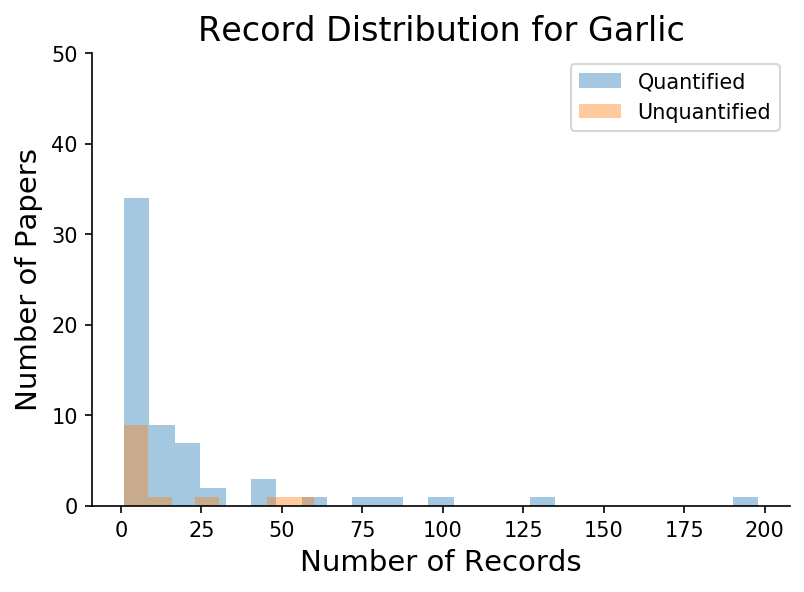

In [20]:
_, ax = plt.subplots(figsize=(6, 4))

# Distrubtion of chemical measurements per paper (number of records)
quant_viz = food_data_q.groupby('PMID').agg({'chemical' : 'count'}).reset_index().rename(columns={'chemical' : 'count'})
unquant_viz = food_data_dnq.groupby('PMID').agg({'chemical' : 'count'}).reset_index().rename(columns={'chemical' : 'count'})

yupperbound = 50

display(quant_viz[quant_viz['count'] == max(quant_viz['count'])])

g1 = sns.distplot(quant_viz['count'], kde=False, label='Quantified')
g2 = sns.distplot(unquant_viz['count'], kde=False, label='Unquantified')
g1.set_ylim(top = yupperbound)
g1.set_xlabel('Number of Records', fontsize=14)
g1.set_ylabel('Number of Papers', fontsize=14)

g1.set_title(f'Record Distribution for {food.capitalize()}', fontsize=16)

g1.legend()
clean_plot()

,PMID,count
26,19139589,30


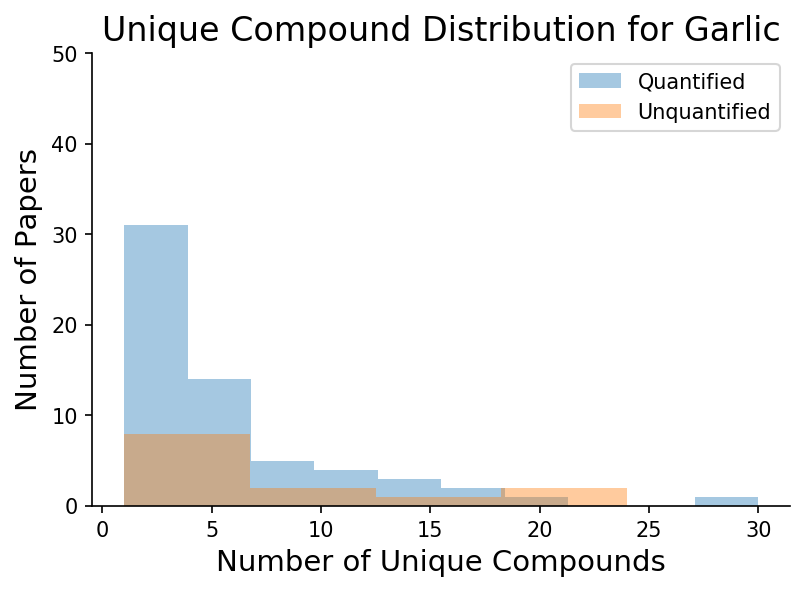

In [21]:
# Distrubtion of chemical measurements per paper (number of records)
quant_viz = food_data_q[['PMID', 'chemical']].drop_duplicates().groupby('PMID').agg({'chemical' : 'count'}).reset_index().rename(columns={'chemical' : 'count'})
unquant_viz = food_data_dnq[['PMID', 'chemical']].drop_duplicates().groupby('PMID').agg({'chemical' : 'count'}).reset_index().rename(columns={'chemical' : 'count'})

display(quant_viz[quant_viz['count'] == max(quant_viz['count'])])

g1 = sns.distplot(quant_viz['count'], kde=False, label='Quantified')
g2 = sns.distplot(unquant_viz['count'], kde=False, label='Unquantified')
g1.set_ylim(top = yupperbound)
g1.set_xlabel('Number of Unique Compounds', fontsize=14)
g1.set_ylabel('Number of Papers', fontsize=14)

g1.set_title(f'Unique Compound Distribution for {food.capitalize()}', fontsize=16)

g1.legend()
clean_plot()

### Figure 2

In [22]:
# Load data for chemical classes
if food == 'garlic':
    classdata = pd.read_csv("data/Garlic_Quant_Cleaned.csv", encoding='latin1')
if food == 'cocoa':
    classdata = pd.read_csv("data/cocoa_quant_cleaned.csv", encoding='latin1').rename(columns={'Name' : 'name'})

classdata = classdata[['name','InChIKey', 'SuperClass', 'Class', 'SubClass']]
classdata.columns = ['chemical', 'InChiKey', 'SuperClass', 'Class', 'SubClass']
classdata = classdata[classdata.Class.notnull()]

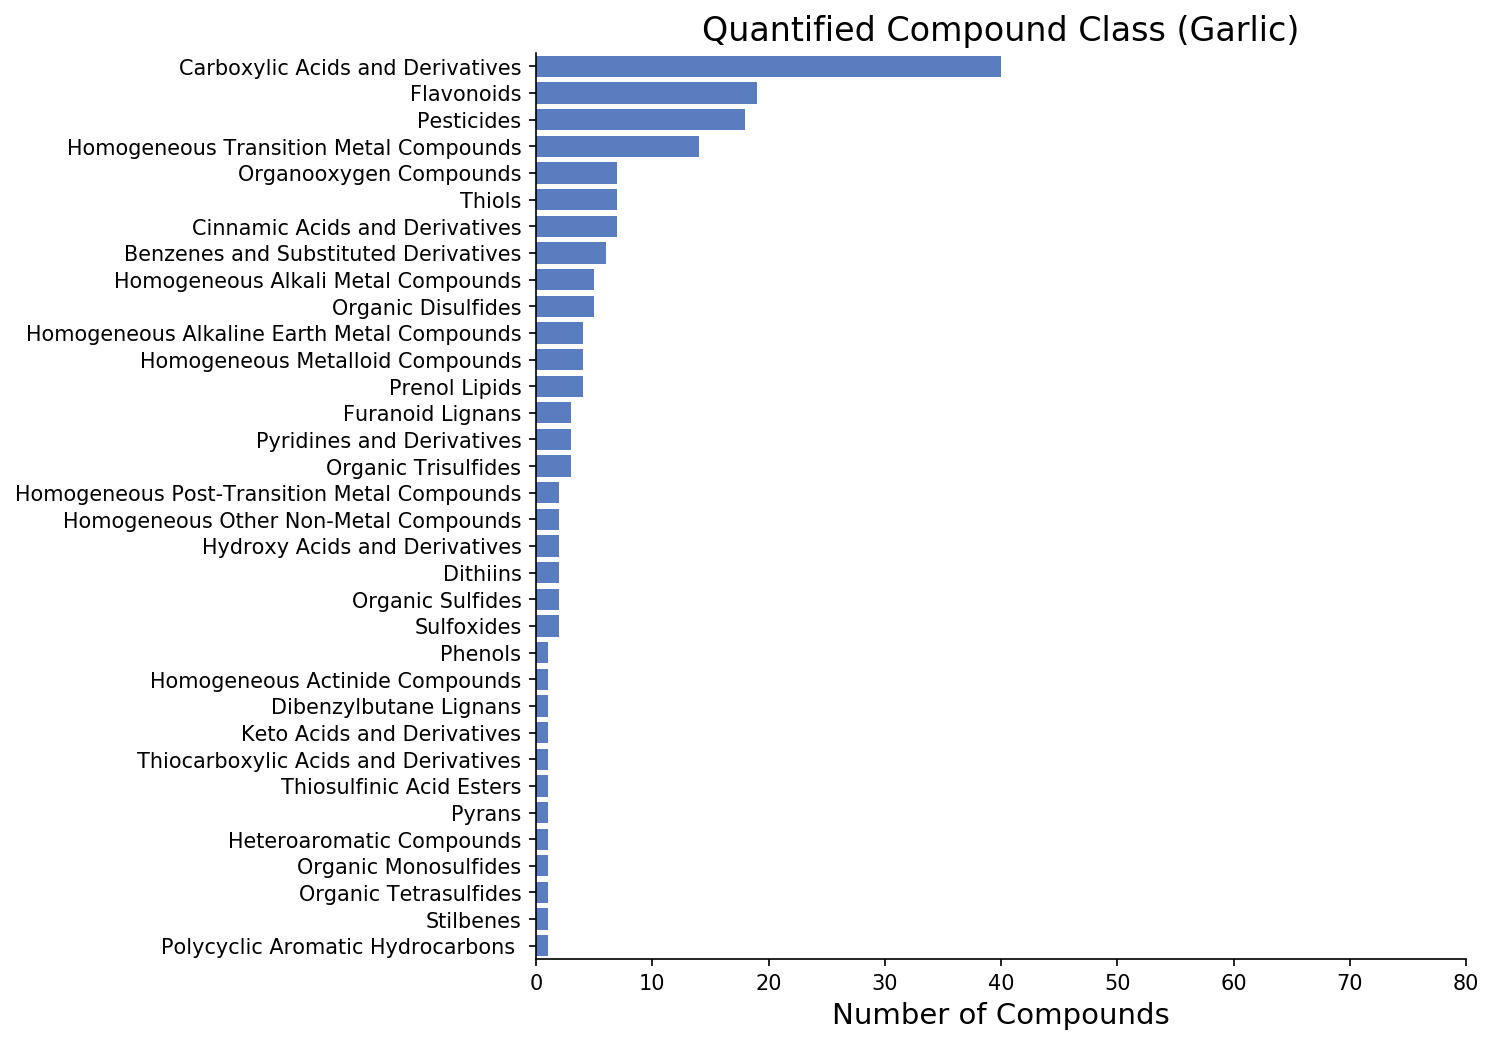

In [23]:
sns.set_color_codes(palette='muted')

fig, _ = plt.subplots(figsize=(8,8))
terms = classdata.Class.tolist()
top_n = 100 # Ensurces all classes are present

counter = Counter(terms)

# Get counts of classes
counter = dict(counter.most_common(top_n))

# Extract ordered keys and corresponding values, then plot
terms = [str(k) for k in counter.keys()]
term_counts = list(counter.values())
ax = sns.barplot(term_counts, terms, color='b')

ax.set_title(f'Quantified Compound Class ({food.capitalize()})', fontsize=16)

ax.set_xlabel('Number of Compounds', fontsize=14)
ax.set_xlim([0, 80])
clean_plot()

### Figure 3

In [24]:
# Colors at https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/
def partition_df(df, content_col, id_col, str_col):
    quant = df[df[content_col] > 0]
    unquant = df[(df[content_col].isnull()) & (~df[id_col].isin(set(quant[id_col].dropna().tolist())))
                & (~df[str_col].isin(set(quant[str_col].dropna().tolist())))]
    zeros = df[(df[content_col] == 0) & (~df[id_col].isin(set(quant[id_col].dropna().tolist() + unquant[id_col].dropna().tolist())))
              & (~df[id_col].isin(set(quant[str_col].dropna().tolist() + unquant[str_col].dropna().tolist())))]
    
    return quant, unquant, zeros

fdb_q, fdb_uq, fdb_z = partition_df(foodb_food,'standard_content', 'chem_id' , 'chem_id_f')

fdb_quant_num_nz = len(fdb_q[fdb_q.chem_id.notnull()].drop_duplicates('chem_id')) + len(fdb_q[fdb_q.chem_id.isnull()].drop_duplicates('chem_id_f'))
fdb_quant_num_z = len(fdb_z[fdb_z.chem_id.notnull()].drop_duplicates('chem_id')) + len(fdb_z[fdb_z.chem_id.isnull()].drop_duplicates('chem_id_f'))
fdb_unquant_num = len(fdb_uq[fdb_uq.chem_id.notnull()].drop_duplicates('chem_id')) + len(fdb_uq[fdb_uq.chem_id.isnull()].drop_duplicates('chem_id_f'))

fm_q, fm_uq, fm_z = partition_df(food_mine,'average_mean', 'chem_id', 'chemical')

fm_q_nz = len(fm_q[fm_q.chem_id.notnull()].drop_duplicates('chem_id')) + len(fm_q[fm_q.chem_id.isnull()].drop_duplicates('chemical'))
fm_q_z = len(fm_z[fm_z.chem_id.notnull()].drop_duplicates('chem_id')) + len(fm_z[fm_z.chem_id.isnull()].drop_duplicates('chemical'))
fm_nuq = len(fm_q[fm_q.chem_id.notnull()].drop_duplicates('chem_id')) + len(fm_q[fm_q.chem_id.isnull()].drop_duplicates('chemical'))


u_q, u_uq, u_z = partition_df(unique_chems,'average_mean', 'chem_id', 'chemical')

fm_u_nz = len(u_q[u_q.chem_id.notnull()].drop_duplicates('chem_id')) + len(u_q[u_q.chem_id.isnull()].drop_duplicates('chemical'))
fm_u_z = len(u_z[u_z.chem_id.notnull()].drop_duplicates('chem_id')) + len(u_z[u_z.chem_id.isnull()].drop_duplicates('chemical'))

unquantcolor = sns.color_palette("Paired", 10)[1]
quantcolor = sns.color_palette("Paired", 10)[0]
uniquecolor = sns.color_palette("Paired")[6]

In [25]:
# Visualize final chems
disp_nums = {'db' : ['USDA', 'Foodb', 'FoodMine', 'FoodMine, New Info'],
             'Quantified' : [len(usda[usda.Nutr_Val != 0]), fdb_quant_num_nz, fm_q_nz, fm_u_nz],
             'Zeros' : [len(usda[usda.Nutr_Val == 0]), fdb_quant_num_z, fm_q_z, fm_u_z],
             'Unquantified' : [0, fdb_unquant_num, len(fm_uq), 0]}

disp_df = pd.DataFrame(disp_nums)

disp_df['total'] = disp_df['Quantified'] + disp_df['Zeros'] + disp_df['Unquantified']

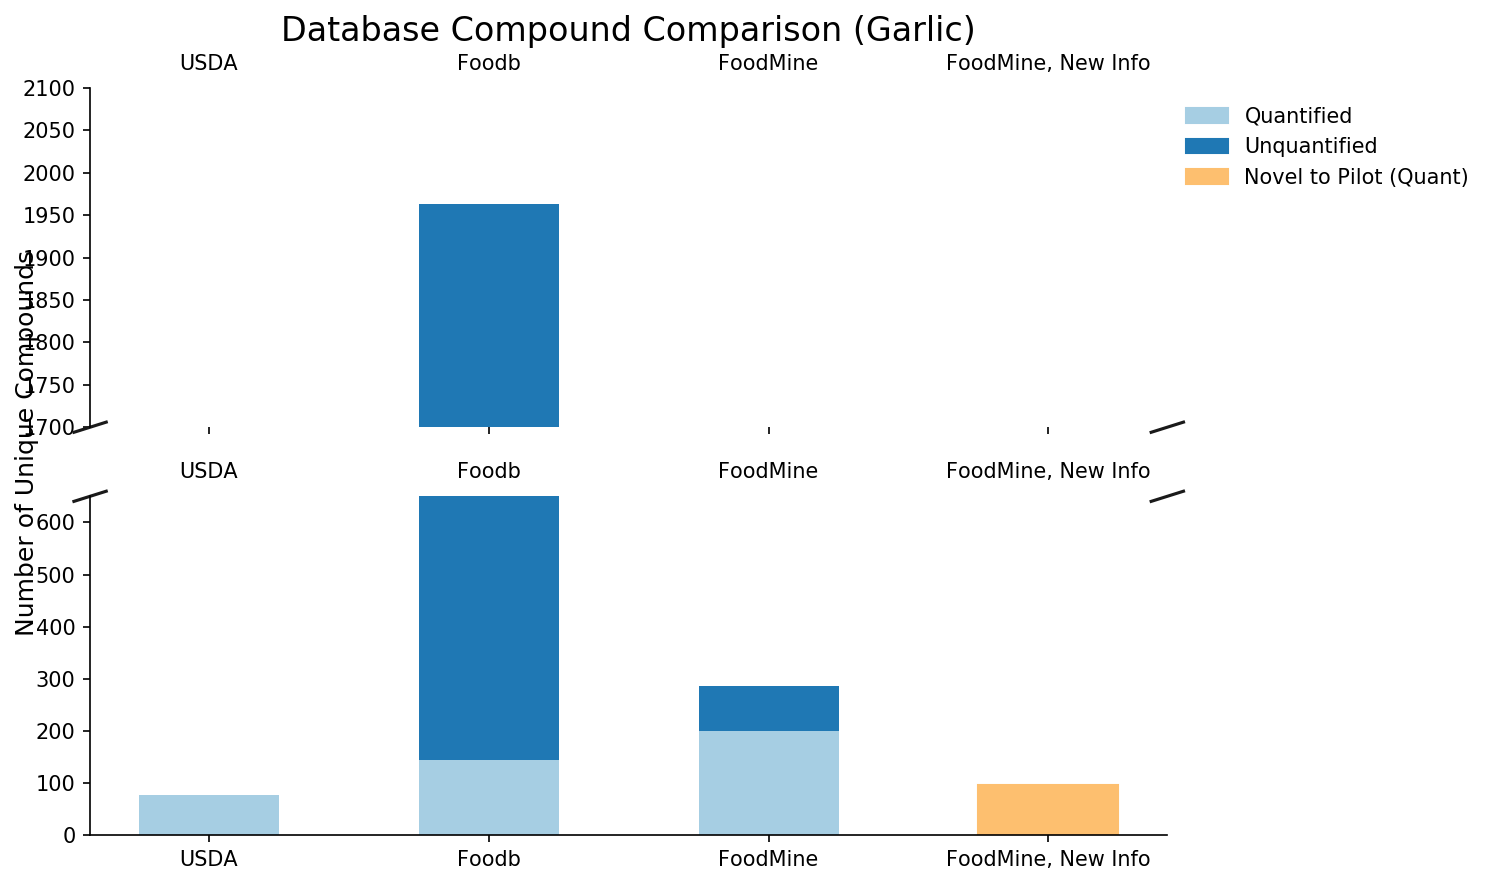

In [26]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))

# plot the same data on both axes
index = np.arange(4)
bar_width = .5

ax.bar(index, disp_df['total'], bar_width, color = unquantcolor)

rects1 = ax2.bar(index, disp_df['Quantified'], bar_width, color = quantcolor)
rects2 = ax2.bar(index, disp_df['Unquantified'], bar_width, bottom = disp_df['Quantified'], color = unquantcolor)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(1700, 2100)  # outliers only
ax2.set_ylim(0, 650)  # most of the data

# Set the ticks and ticklabels for all axes
plt.setp(ax2, xticks=index, xticklabels=disp_df['db'].tolist())

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.tick_params(labeltop='off', bottom='off')  # don't put tick labels at the top
ax2.tick_params(labeltop='off', bottom='off')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

f.text(0.01, 0.5, 'Number of Unique Compounds', va='center', rotation='vertical', fontsize=12)
ax.set_title(f'Database Compound Comparison ({food.capitalize()})', fontsize=16)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

ax2.get_children()[3].set_color(uniquecolor)

patch1 = mpatches.Patch(color=quantcolor, label='Quantified')
patch2 = mpatches.Patch(color=unquantcolor, label='Unquantified')
patch3 = mpatches.Patch(color=uniquecolor, label='Novel to Pilot (Quant)')
ax.legend(handles = [patch1, patch2, patch3], frameon = False, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()


### Figure 4

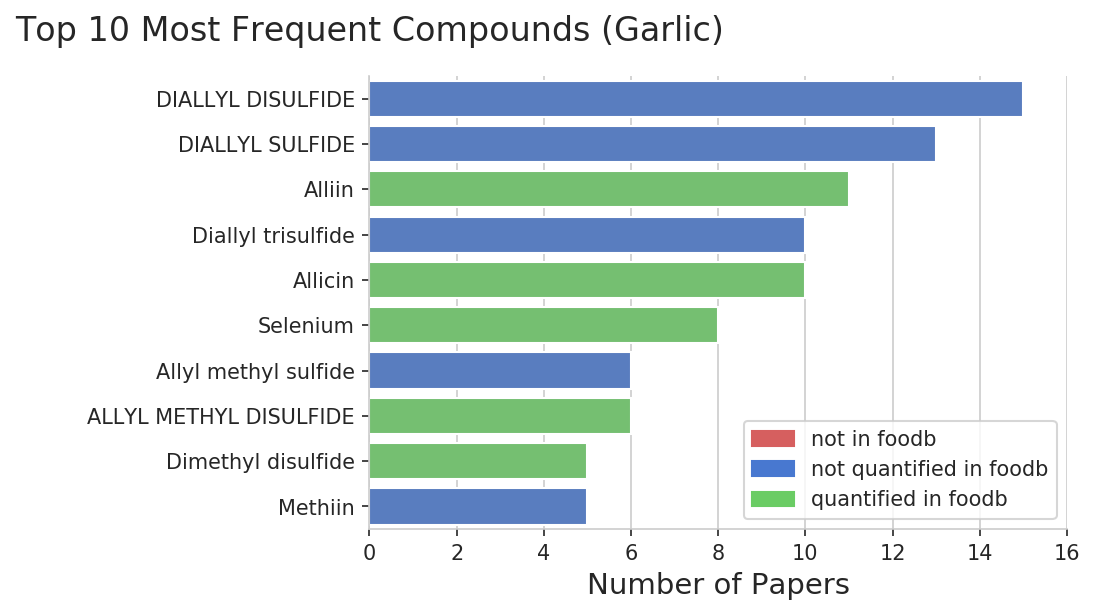

In [27]:
# Calculates top n for number of papers a chemical occurs in
expanded_term_list = []
for idx, row in food_mine.iterrows():
    if row['chemical'] == 'fat':
        continue
    expanded_term_list += [row['chem_id']] * int(row['num_papers'])

# Note that this particular iteration doesn't account for id's that are NaN, but all top values seem to have id's anyways
id_to_name = []
for ID in expanded_term_list:
    name = food_mine[food_mine['chem_id'] == ID].chemical.tolist()
    
    if isinstance(name, list):
        if len(name) == 0:
            continue
        id_to_name.append(name[0])
    else:
        id_to_name.append(name)

terms = id_to_name
top_n = 10

title = f"Top 10 Most Frequent Compounds ({food.capitalize()})"

f_ids = set(foodb_food.chem_id.tolist())
f_q_ids = set( foodb_food[foodb_food.standard_content > 0].chem_id.tolist())

counter = Counter(terms)

counter = dict(counter.most_common(top_n))

terms = [str(k) for k in counter.keys()]
term_counts = list(counter.values())

sns.set_color_codes('muted')

c1 = 'r'
c2 = 'b'
c3 = 'g'

colors = []
labels = []
for v in terms:
    temp_id = food_mine[food_mine.chemical==v].chem_id.tolist()[0]
    
    if temp_id in f_q_ids:
        colors.append(c3) # quantified in foodb
    elif temp_id in f_ids:
        colors.append(c2) # not quantified in foodb
    else:
        colors.append(c1) # not in foodb

# Horizontal bar graph

with sns.axes_style('whitegrid'):

    ax = sns.barplot(term_counts, terms, palette=colors)
    #ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of Papers', fontsize=14)
    ax.set_title(title, fontsize = 16)
    ax.title.set_position([0, 1.05])

    patch1 = mpatches.Patch(color=c1, label='not in foodb')
    patch2 = mpatches.Patch(color=c2, label='not quantified in foodb')
    patch3 = mpatches.Patch(color=c3, label='quantified in foodb')
    ax.legend(handles = [patch1, patch2, patch3])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(right = 16)


### Figure 5

In [28]:
usda_mod = usda[(usda.unit != 'IU') & (usda.chem_id.notnull())]

for idx, row in usda_mod.iterrows():
    try:
        usda_mod.at[idx, 'usda_amount'] = collected_data_handling.__unit_handler__(row['Nutr_Val'], row['unit'] + '/100g', 'mg/100g')
    except:
        pass

usda_mod['units'] = 'mg/100g'

usda_mod.to_pickle(f'misc_save/{food}_usda_conv.pkl')

C:\software\Anaconda3\envs\advanced\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\software\Anaconda3\envs\advanced\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\software\Anaconda3\envs\advanced\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [29]:
val_comparison = quant_food_mine.merge(usda_mod[['chem_id','usda_amount']].groupby('chem_id').mean().reset_index(),
                                       how = 'inner', on = 'chem_id')
val_comparison = val_comparison[val_comparison.num_terms_quantified != 0]
val_comparison = val_comparison[(val_comparison.average_mean != 0) & (val_comparison.usda_amount != 0)]
val_comparison = val_comparison.sort_values(by=['average_mean'], ascending=False).reset_index(drop=True)

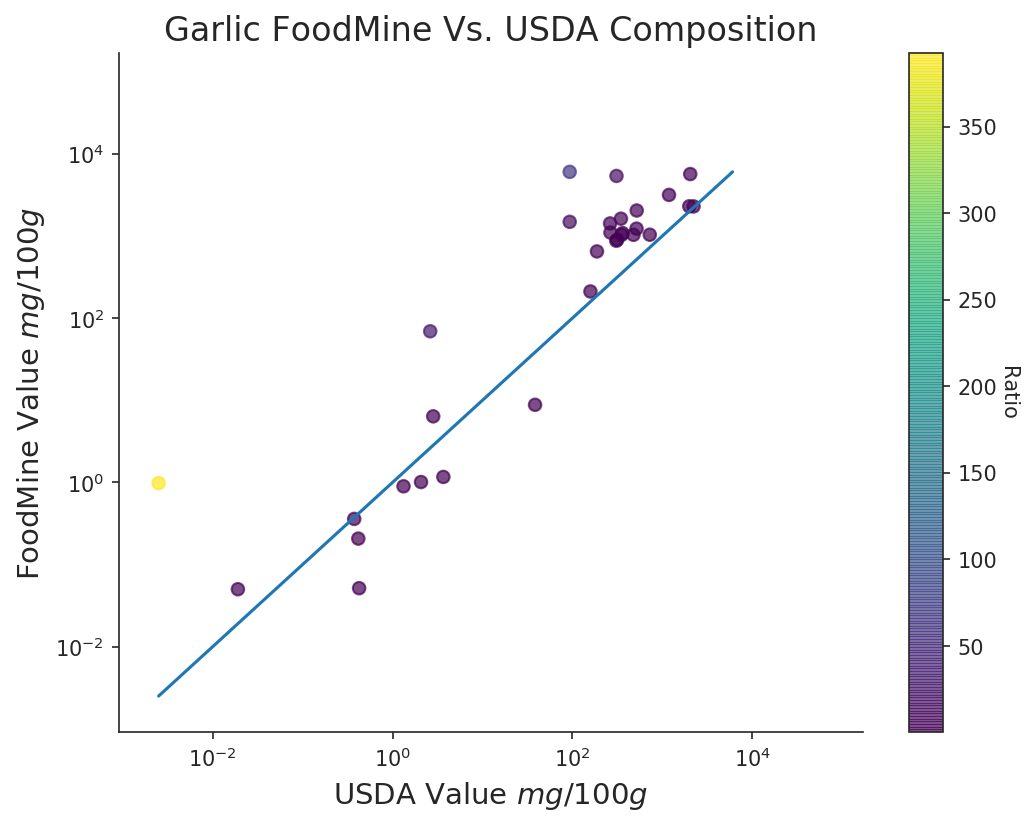

In [30]:
import math
import scipy

color_values = [(row['average_mean'])/(row['usda_amount']) for _, row in val_comparison.iterrows()]

input1 = val_comparison['usda_amount'].tolist()
input2 = val_comparison['average_mean'].tolist()

x_min = 10**-3
x_max = 10**5
y_min = 10**-3
y_max = 10**5

if x_min == 0 or y_min == 0:
    x_min = max(x_min,y_min)
    y_min = max(x_min,y_min)

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot([min(input1), max(input2)],[min(input1), max(input2)])

    f = ax.scatter(input1, input2, c=color_values,
               cmap='viridis', marker='o', alpha=.7)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([x_min * .9, x_max * 1.7])
    ax.set_ylim([y_min * .9, y_max * 1.7])

    ax.set_xlabel(r"USDA Value $mg/100g$", fontsize=14)
    ax.set_ylabel(r"FoodMine Value $mg/100g$", fontsize=14)
    
    ax.set_title(f'{food.capitalize()} FoodMine Vs. USDA Composition', fontsize=16)

    cbar = plt.colorbar(f)
    cbar.set_label('Ratio', rotation=270, labelpad=+10)

    wnames = False
    if wnames:
        for i, txt in enumerate(val_comparison.chemical.tolist()):
            plt.annotate(txt, (input1[i] * 1.1, input2[i]))

clean_plot()

corr = scipy.stats.pearsonr(val_comparison.average_mean.apply(np.log), val_comparison.usda_amount.apply(np.log))[0]**2
report_stat(f'perc {food} fm data used w/ usda: ' + str(len(val_comparison)/len(food_mine)), f'fm_usda_overlap_perc_{food}.txt')
report_stat(f'FM-USDA log R2 {food}: ' + str(corr), f'fm_usda_r2_{food}.txt')

In [31]:
def filter_papers(l, v=None):
    if v in l:
        return True
    else:
        return False

new_calc = val_comparison[~val_comparison.papers.apply(filter_papers, v=16848542)]
corr = scipy.stats.pearsonr(new_calc.average_mean.apply(np.log), new_calc.usda_amount.apply(np.log))[0]**2
report_stat(f'FM-USDA removed paper log R2 {food}: ' + str(corr), f'fm_usda_r2_r_{food}.txt')

In [32]:
import statsmodels.api as sm

X = val_comparison.average_mean.apply(np.log)
Y = val_comparison.usda_amount.apply(np.log)

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

C:\software\Anaconda3\envs\advanced\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            usda_amount   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     132.6
Date:                Fri, 13 Dec 2019   Prob (F-statistic):           2.45e-12
Time:                        16:29:56   Log-Likelihood:                -56.285
No. Observations:                  31   AIC:                             116.6
Df Residuals:                      29   BIC:                             119.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2280      0.442     -0.516   

In [33]:
X = new_calc.average_mean.apply(np.log)
Y = new_calc.usda_amount.apply(np.log)

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            usda_amount   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     132.6
Date:                Fri, 13 Dec 2019   Prob (F-statistic):           2.45e-12
Time:                        16:29:56   Log-Likelihood:                -56.285
No. Observations:                  31   AIC:                             116.6
Df Residuals:                      29   BIC:                             119.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2280      0.442     -0.516   